In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta
import matplotlib.ticker as ticker

In [128]:
'''Create empty Dataframe'''
my_index = pd.MultiIndex(levels=[[],[],[]],
                         codes=[[],[],[]],
                             names=[u'STime', u'Point', u'Index'])
my_columns = [u'Year', u'Month',u'Day',u'Hour',u'Minute',u'Second',u'x',u'y',u'theta',u'Record',u'U (m s^-1)',u'V (m s^-1)',u'W (m s^-1)',u'TSonic (K)',u'RH (%)',u'T_HMP60 (C)']
data = pd.DataFrame(index=my_index, columns=my_columns)

'''IMPORT DATA'''
files = ['08-00','08-30','09-00','09-30','10-00','10-30','11-00','11-30',
        '12-00','12-30','13-00','13-30','14-00','14-30','15-00','15-30',
        '16-00','16-30','17-00','17-30','18-00','18-30','19-00','19-30',
        '20-00','20-30','21-00','21-30','22-00','22-30','23-00','23-30',
        '00-00','00-30','01-00','01-30','02-00','02-30','03-00','03-30',
        '04-00','04-30','05-00','05-30','06-00','06-30','07-00','07-30']

for i in files:
    temppd = pd.read_csv('./Data/Binned Data/'+i+'.csv',index_col=[0,1])
    
    #append dataframe into multiframe
    data = data.append(temppd.assign(k=i).set_index('k',append=True).swaplevel(0,2).swaplevel(1,2))
    
#data = data.sort_index() #sort cuz faster

In [129]:
points=['p1','p2','p3','p4','p5','p6','p7','p8']

my_index = pd.MultiIndex(levels=[[],[]],
                         codes=[[],[]],
                             names=[u'STime', u'Point'])
my_columns = [u'Uavg',u'Vavg',u'Wavg','Savg',u'TSonicavg',u'RHavg',u'T_HMP60avg',u'Uvar',u'Vvar',u'Wvar',u'k',
             u'UVvar',u'UWvar',u'VWvar',u'UTvar',u'VTvar',u'WTvar']

p_data = pd.DataFrame(index=my_index, columns=my_columns)

for dtime in tqdm(files):
    for point in points:
        p_data.loc[(dtime,point),'Uavg'] = np.mean(data.loc[(dtime,point),'U (m s^-1)'])
        p_data.loc[(dtime,point),'Vavg'] = np.mean(data.loc[(dtime,point),'V (m s^-1)'])
        p_data.loc[(dtime,point),'Wavg'] = np.mean(data.loc[(dtime,point),'W (m s^-1)'])
        p_data.loc[(dtime,point),'TSonicavg'] = np.mean(data.loc[(dtime,point),'TSonic (K)'])
        p_data.loc[(dtime,point),'RHavg'] = np.mean(data.loc[(dtime,point),'RH (%)'])
        p_data.loc[(dtime,point),'T_HMP60avg'] = np.mean(data.loc[(dtime,point),'T_HMP60 (C)'])+273.15 #shift to Kelvin
        p_data.loc[(dtime,point),'Savg'] = np.mean(np.sqrt(data.loc[(dtime,point),'U (m s^-1)']**2+
                                                           data.loc[(dtime,point),'V (m s^-1)']**2))
        
        
        x = [j for j in range(0, len(data.loc[(dtime,point),'U (m s^-1)']))]
        U = data.loc[(dtime,point),'U (m s^-1)']
        Umodel = np.polyfit(x,U,1)
        Utrend = np.polyval(Umodel,x)
        Udetrended = U - Utrend
        V = data.loc[(dtime,point),'V (m s^-1)']
        Vmodel = np.polyfit(x,V,1)
        Vtrend = np.polyval(Vmodel,x)
        Vdetrended = V - Vtrend
        W = data.loc[(dtime,point),'W (m s^-1)']
        Wmodel = np.polyfit(x,W,1)
        Wtrend = np.polyval(Wmodel,x)
        Wdetrended = W - Wtrend
        TSonic =  data.loc[(dtime,point),'TSonic (K)']
        TSonicmodel = np.polyfit(x, TSonic,1)
        TSonictrend = np.polyval( TSonicmodel,x)
        TSonicdetrended =  TSonic -  TSonictrend
        
        UVCovMatrix = np.cov(Udetrended, Vdetrended)
        UWCovMatrix = np.cov(Udetrended, Wdetrended)
        VWCovMatrix = np.cov(Vdetrended, Wdetrended)
        UTSonicCovMatrix = np.cov(Udetrended, TSonicdetrended)
        VTSonicCovMatrix = np.cov(Vdetrended, TSonicdetrended)
        WTSonicCovMatrix = np.cov(Wdetrended, TSonicdetrended)

        p_data.loc[(dtime,point),'Uvar'] = UVCovMatrix[0,0]
        p_data.loc[(dtime,point),'Vvar'] = UVCovMatrix[1,1]
        p_data.loc[(dtime,point),'Wvar'] = UWCovMatrix[1,1]
        p_data.loc[(dtime,point),'TSonicvar'] = UTSonicCovMatrix[1,1]
        p_data.loc[(dtime,point),'k'] = 1/2*(p_data.loc[(dtime,point),'Uvar']+p_data.loc[(dtime,point),'Vvar']+p_data.loc[(dtime,point),'Wvar'])

        p_data.loc[(dtime,point),'UVvar'] = UVCovMatrix[0,1]
        p_data.loc[(dtime,point),'UWvar'] = UWCovMatrix[0,1]
        p_data.loc[(dtime,point),'VWvar'] = VWCovMatrix[0,1]
        p_data.loc[(dtime,point),'UTvar'] = UTSonicCovMatrix[0,1]
        p_data.loc[(dtime,point),'VTvar'] = VTSonicCovMatrix[0,1]
        p_data.loc[(dtime,point),'WTvar'] = WTSonicCovMatrix[0,1]

    
#print(p_data)

  0%|                                                                                           | 0/48 [00:00<?, ?it/s]C:\Users\jdiro\anaconda3\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.69it/s]


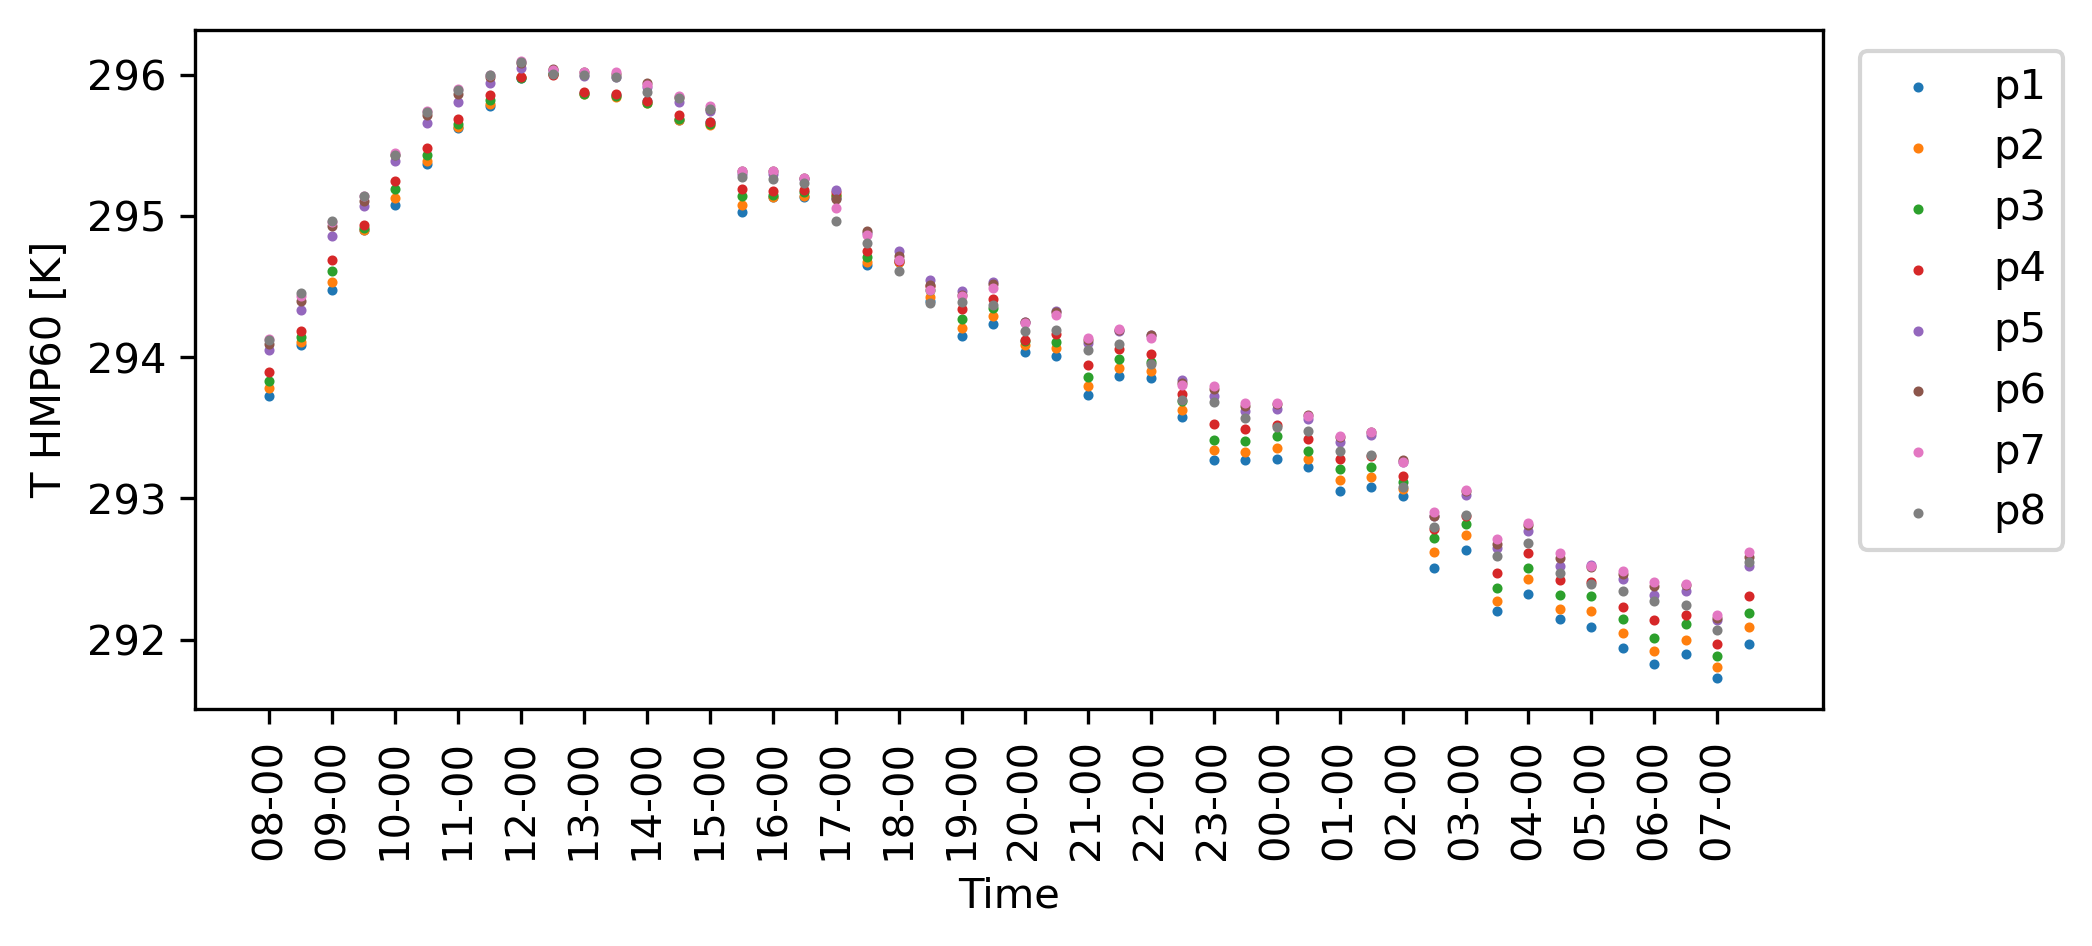

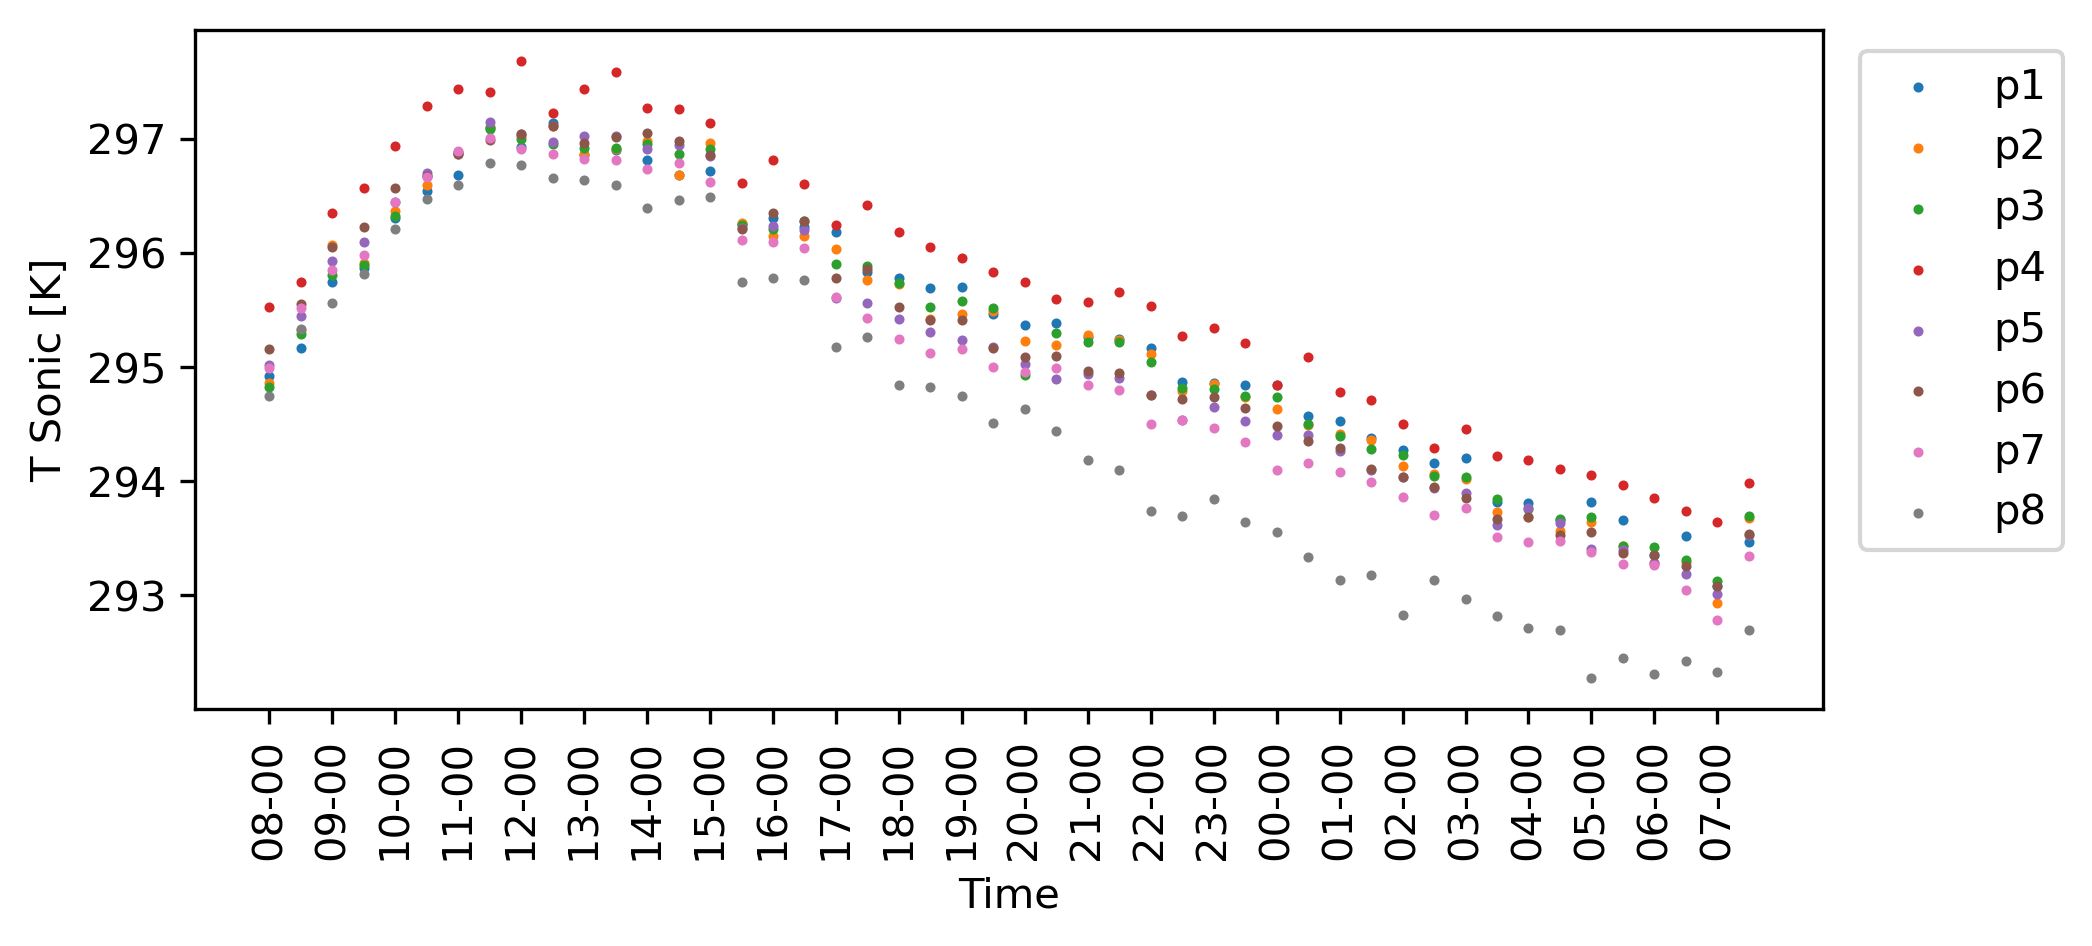

In [158]:
figsavepath = './Analysis/Figures/24Hr_'


x_axis_labels = ['16-00','17-00','18-00','19-00',
            '20-00','21-00','22-00','23-00',
            '00-00','01-00','02-00','03-00',
            '04-00','05-00','06-00','07-00',
            '08-00','09-00','10-00','11-00',
            '12-00','13-00','14-00','15-00']



fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'T_HMP60avg'],label=i,s=2)
plt.ylabel('T HMP60 [K]')
xlabel = plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'HMP60_T_avg.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'TSonicavg'],label=i,s=2)
plt.ylabel('T Sonic [K]')
xlabel = plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'SonicT_avg.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

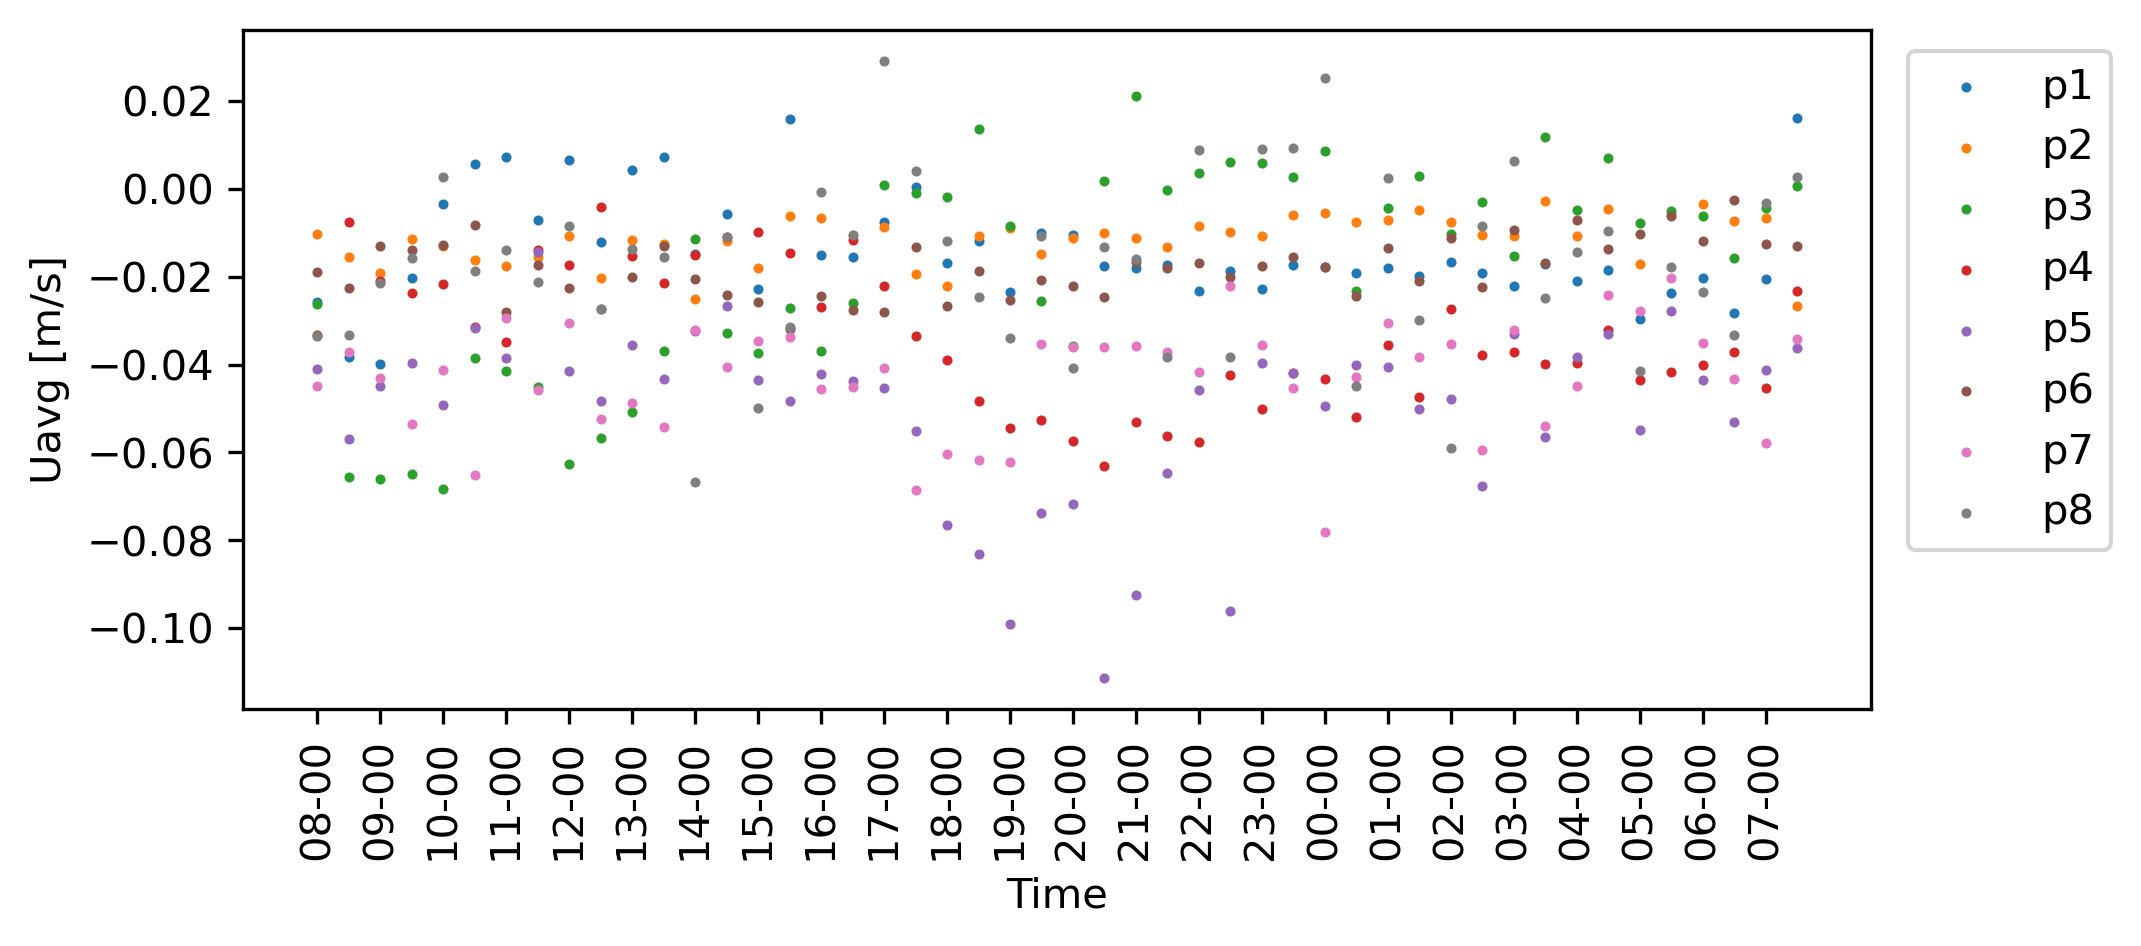

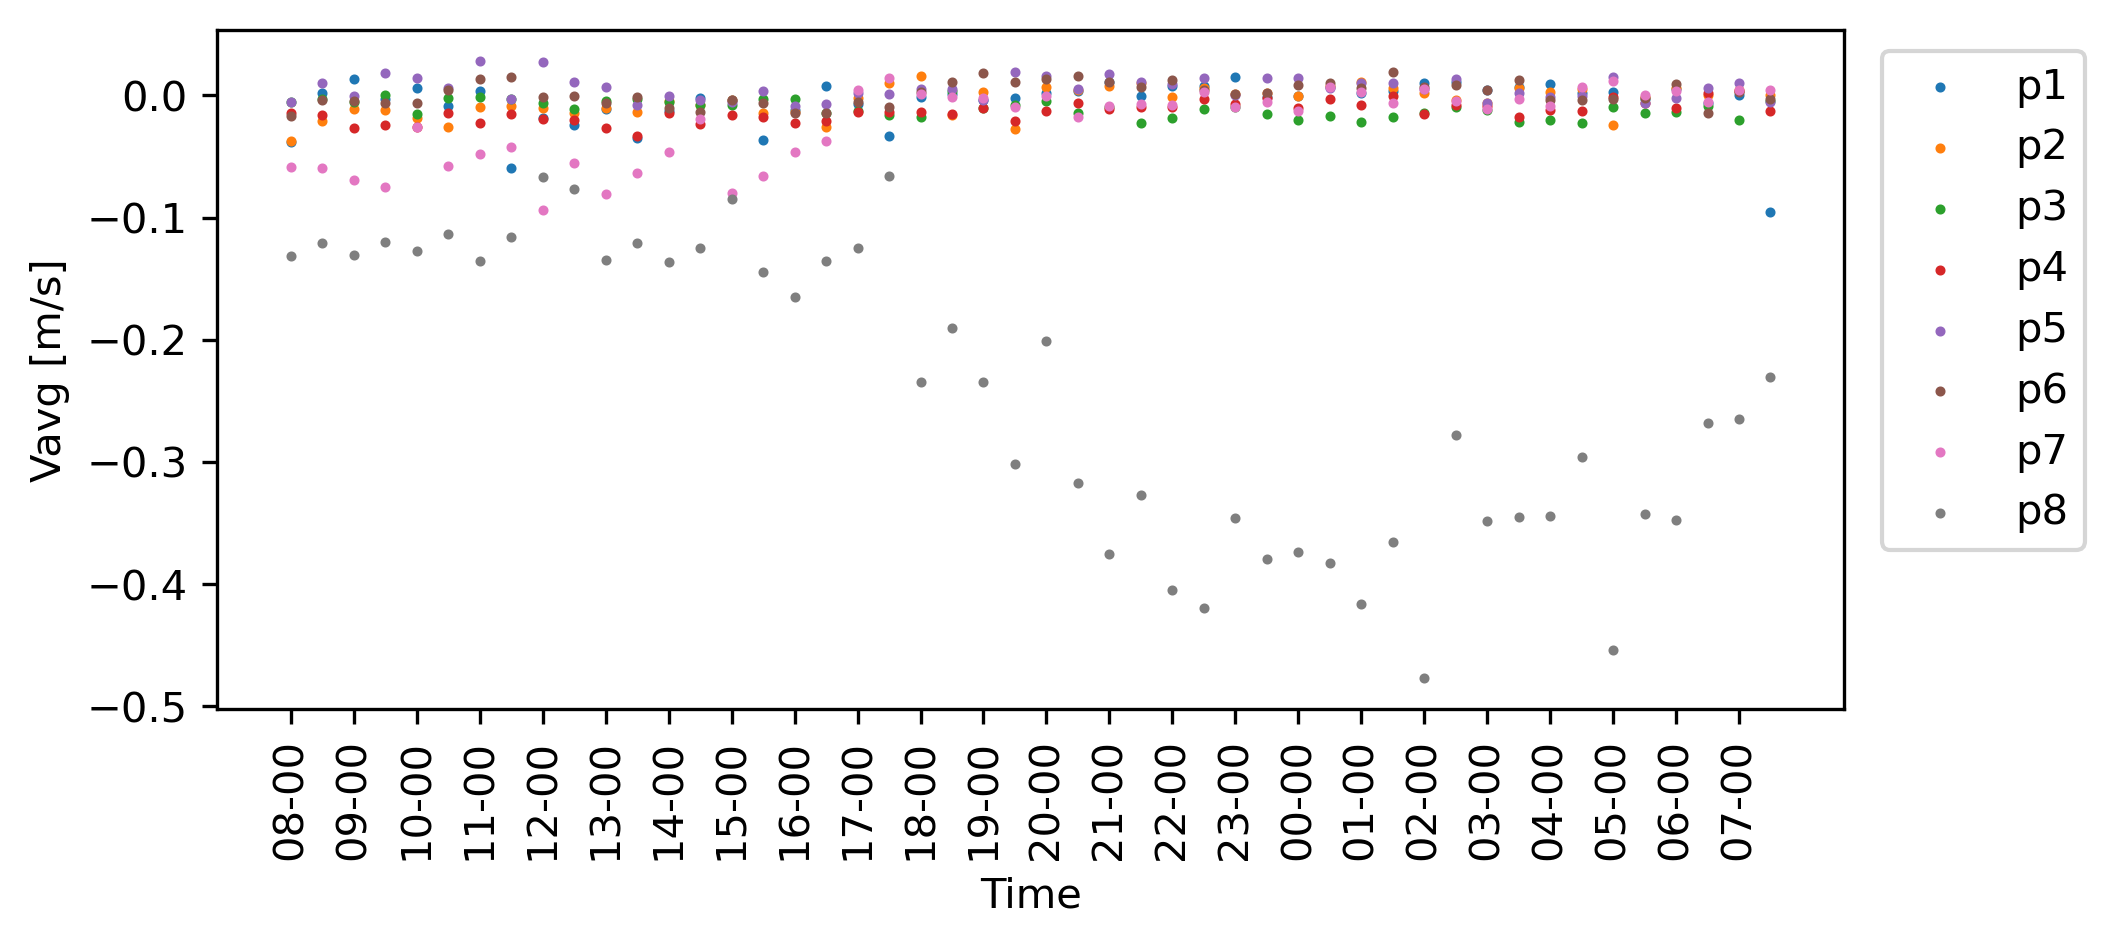

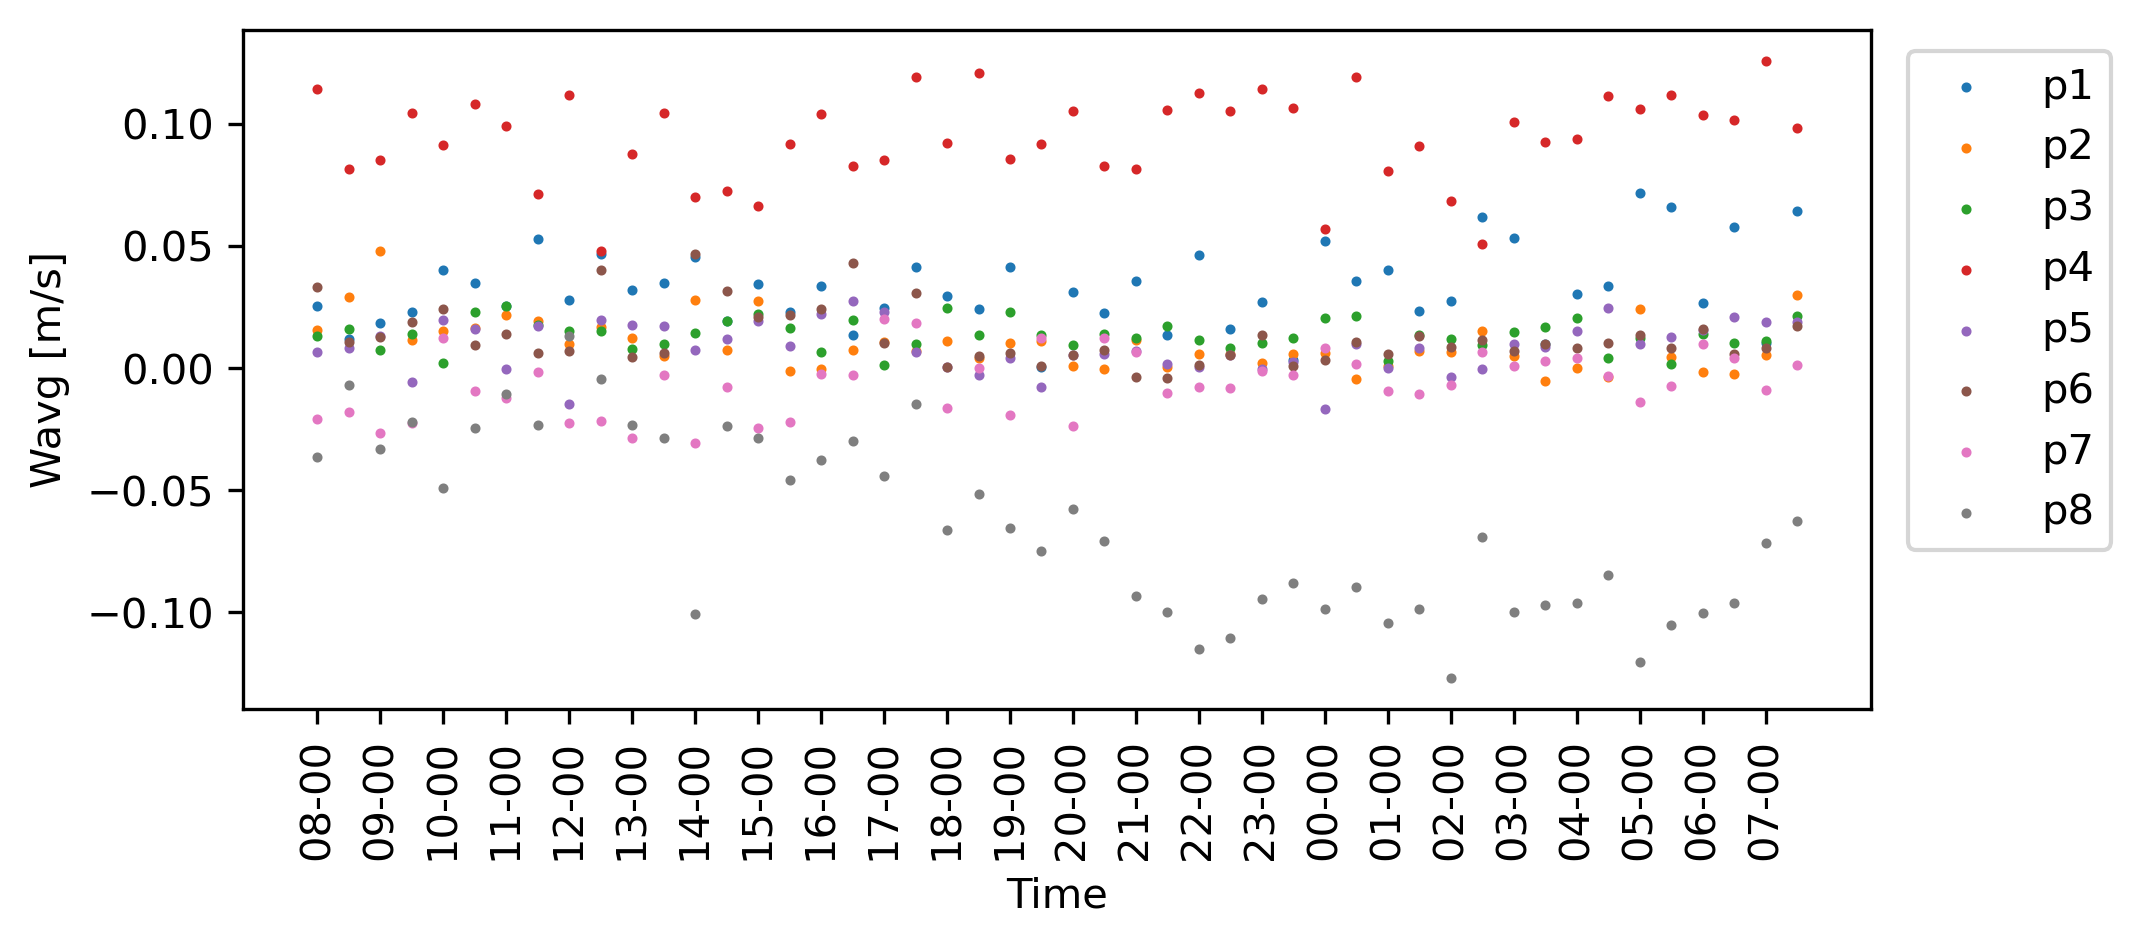

In [159]:
fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'Uavg'],label=i,s=2)
plt.ylabel('Uavg [m/s]')
xlabel = plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'U_avg.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'Vavg'],label=i,s=2)
plt.ylabel('Vavg [m/s]')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'V_avg.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'Wavg'],label=i,s=2)
plt.ylabel('Wavg [m/s]')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'W_avg.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

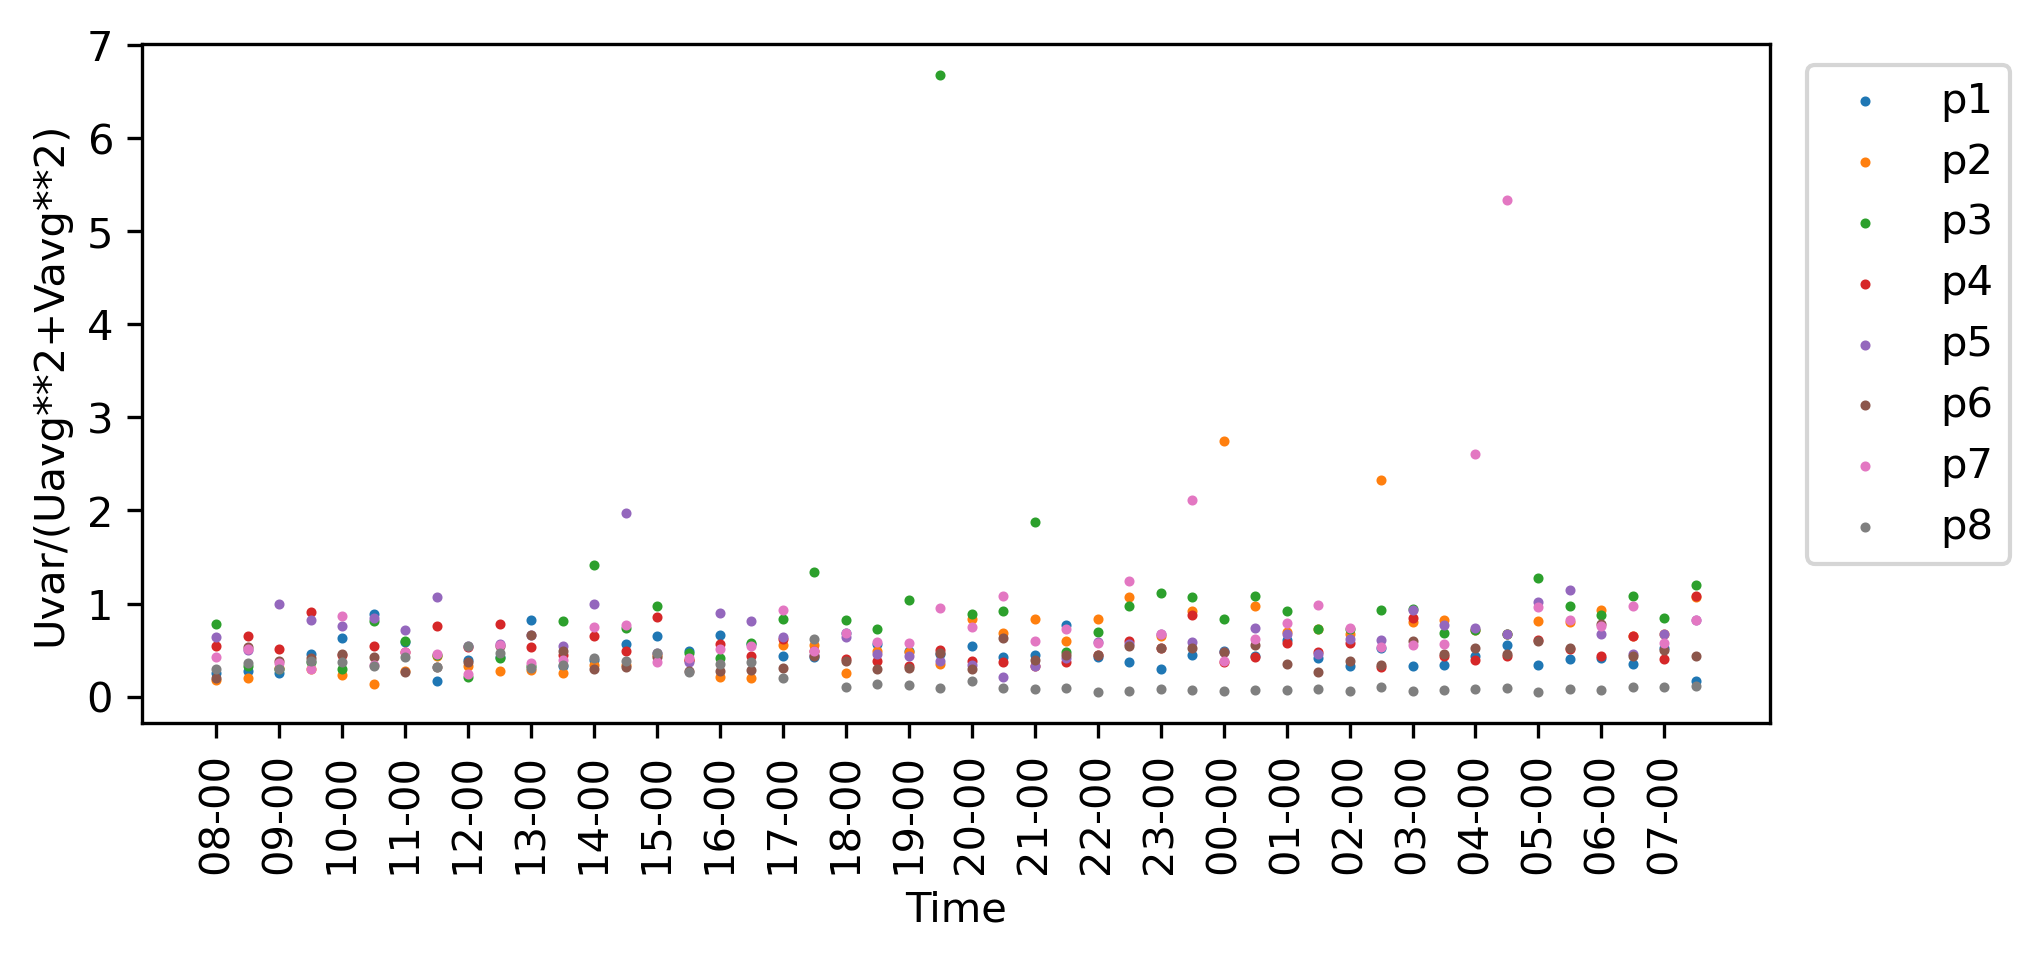

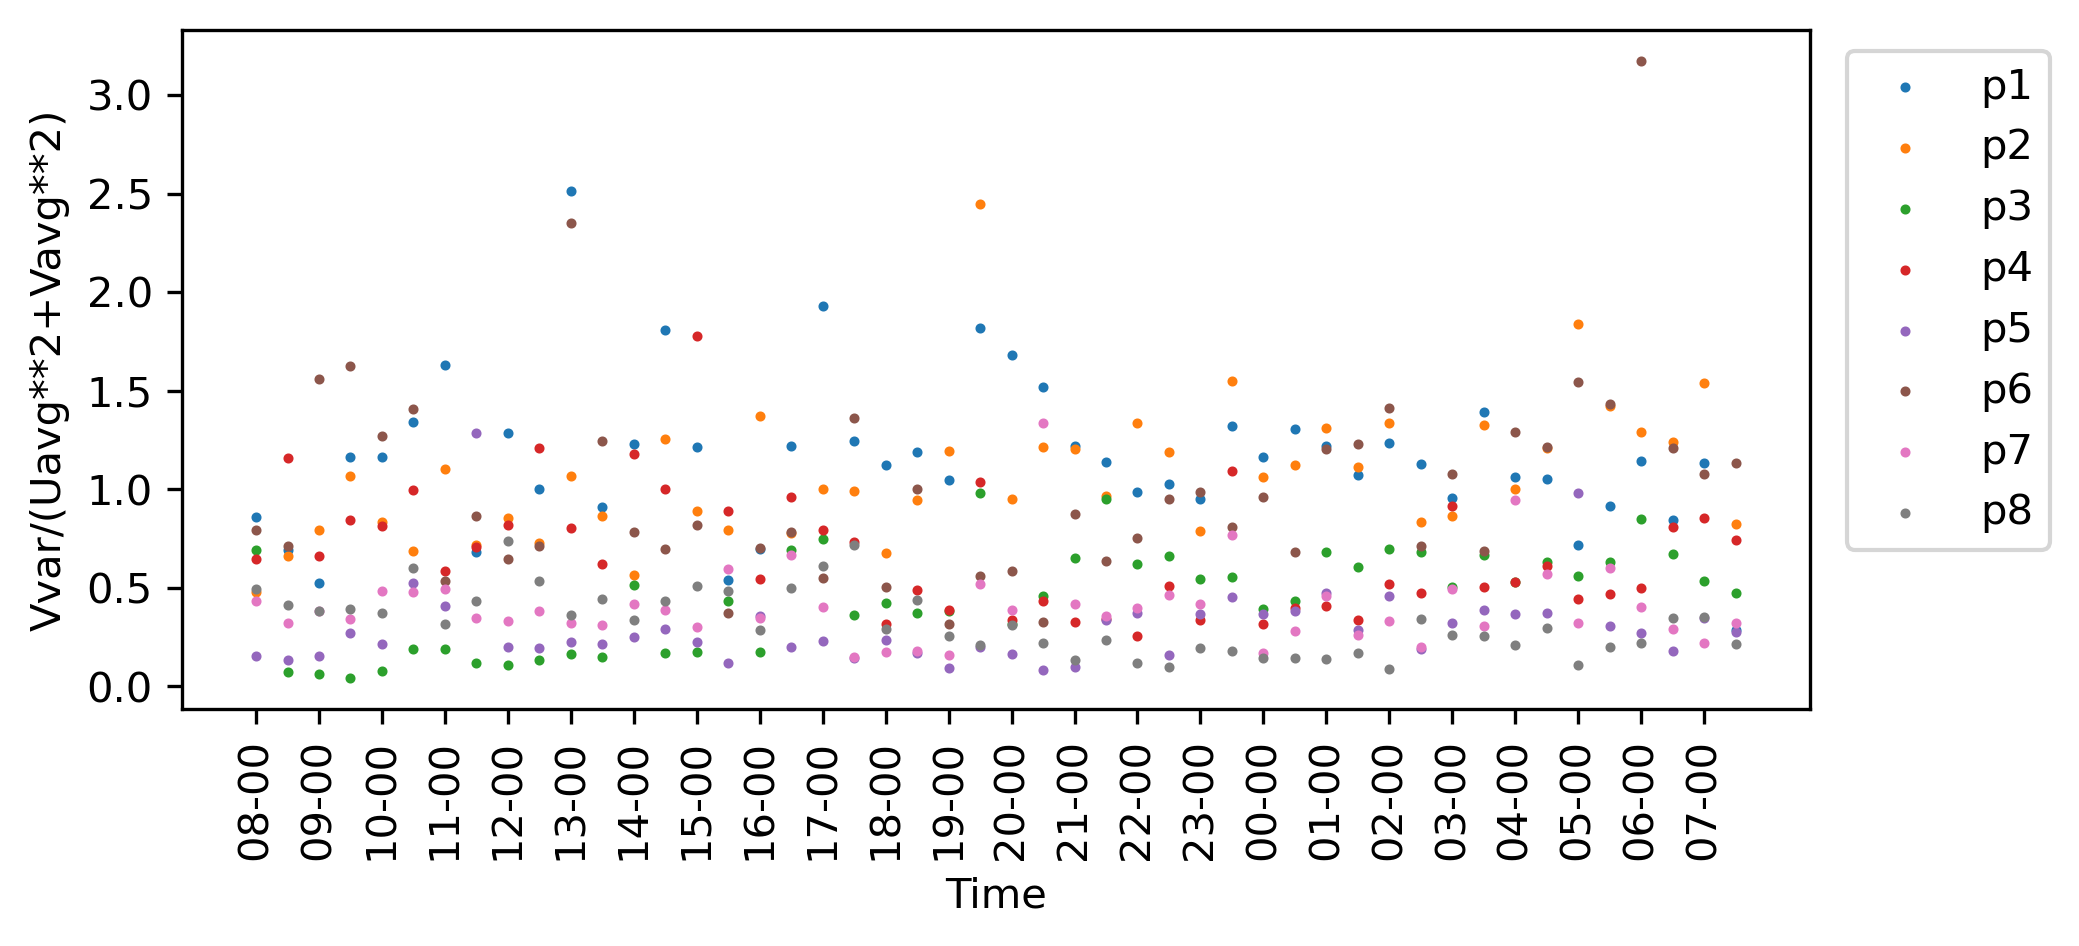

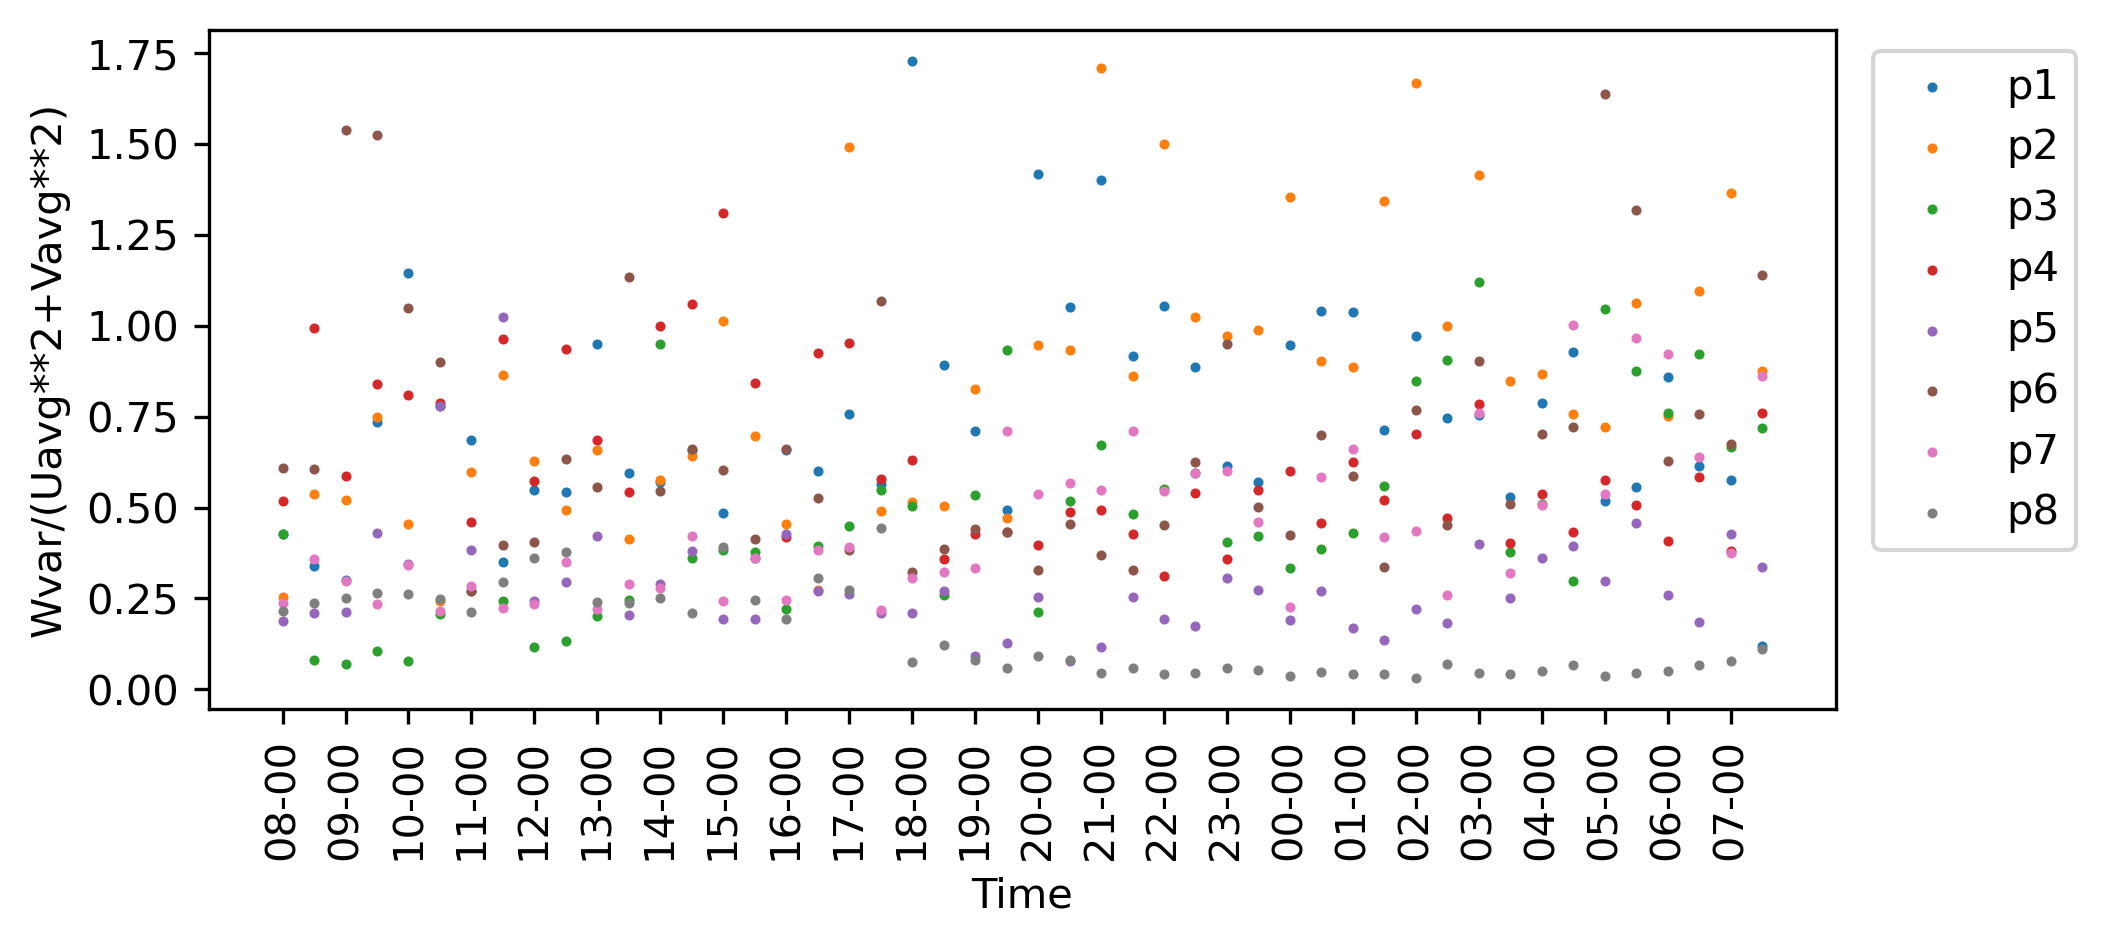

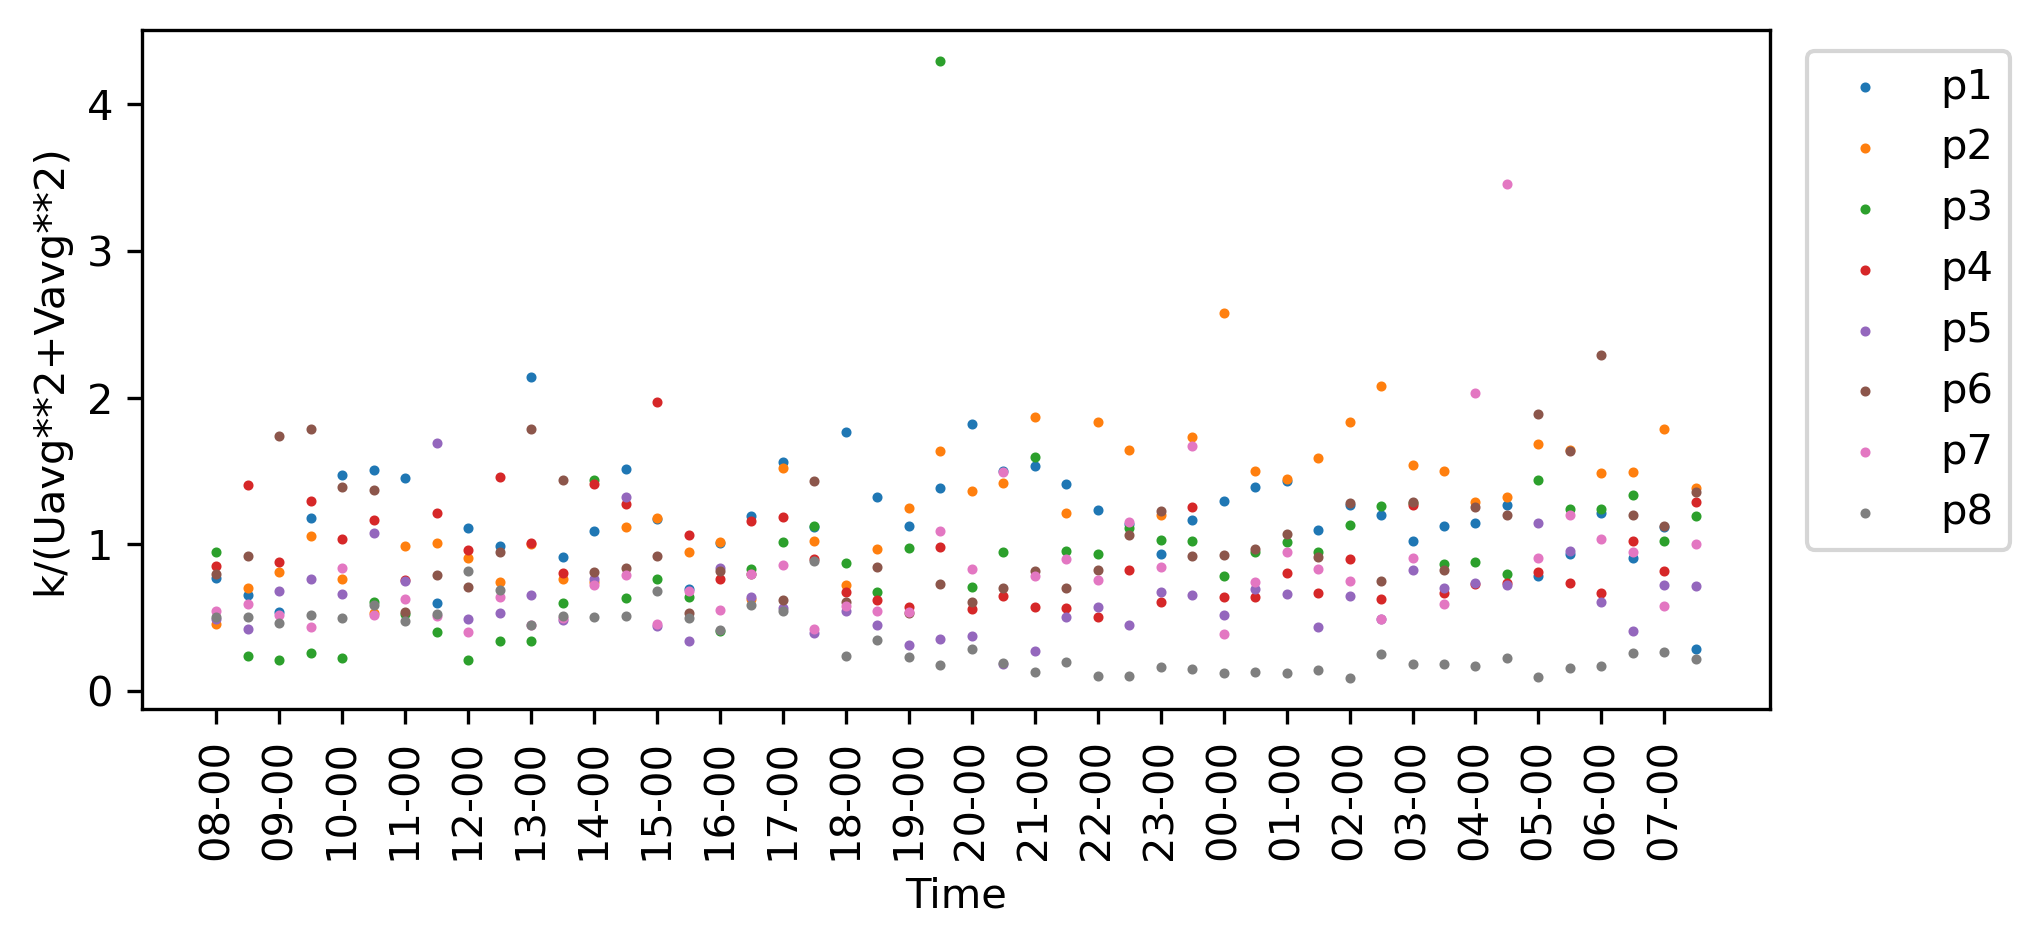

In [160]:
fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'Uvar']/p_data.loc[pd.IndexSlice[:, i], 'Savg']**2,label=i,s=2)
plt.ylabel('Uvar/(Uavg**2+Vavg**2)')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'Uvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'Vvar']/p_data.loc[pd.IndexSlice[:, i], 'Savg']**2,label=i,s=2)
plt.ylabel('Vvar/(Uavg**2+Vavg**2)')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'Vvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'Wvar']/p_data.loc[pd.IndexSlice[:, i], 'Savg']**2,label=i,s=2)
plt.ylabel('Wvar/(Uavg**2+Vavg**2)')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'Wvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'k']/p_data.loc[pd.IndexSlice[:, i], 'Savg']**2,label=i,s=2)
plt.ylabel('k/(Uavg**2+Vavg**2)')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'k.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

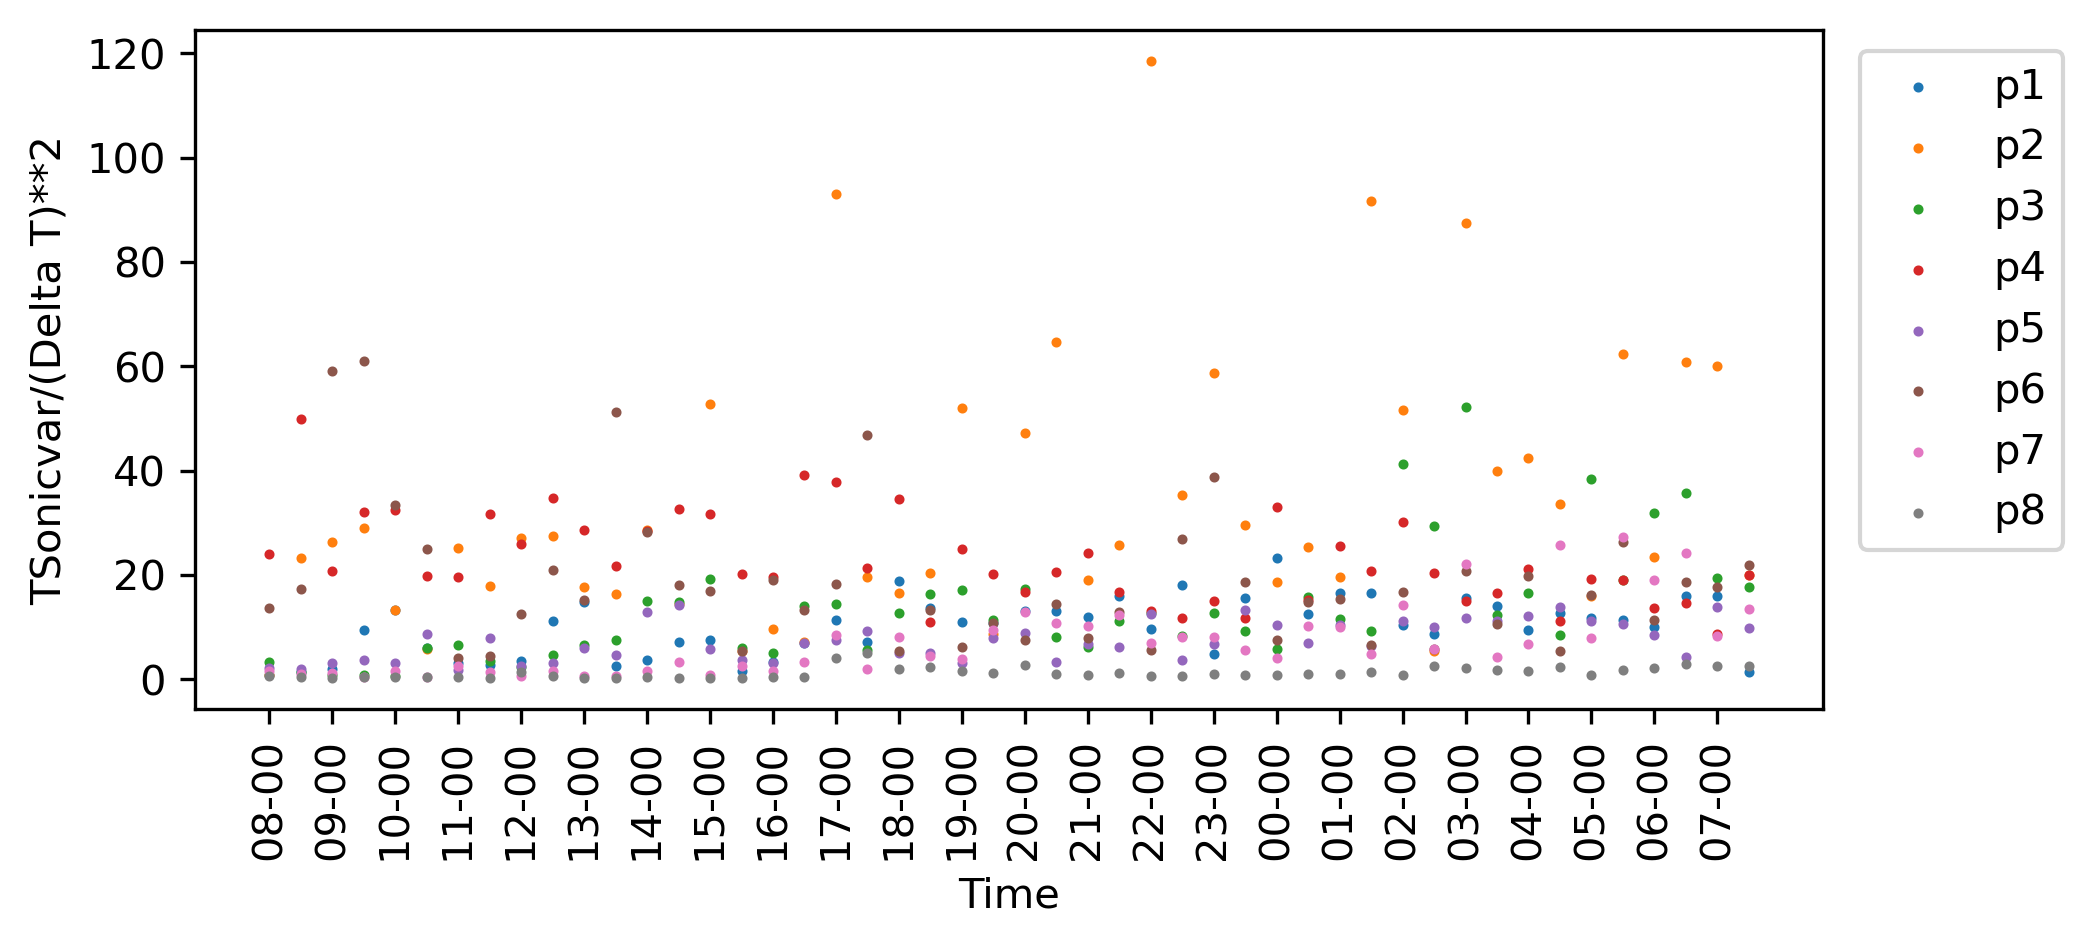

In [161]:
DeltaT=np.max(p_data['TSonicavg'])-np.min(p_data['TSonicavg'])
#print(DeltaT)

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'TSonicvar']/p_data.loc[pd.IndexSlice[:, i], 'Savg']**2,label=i,s=2)
plt.ylabel('TSonicvar/(Delta T)**2')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'TSonicvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()


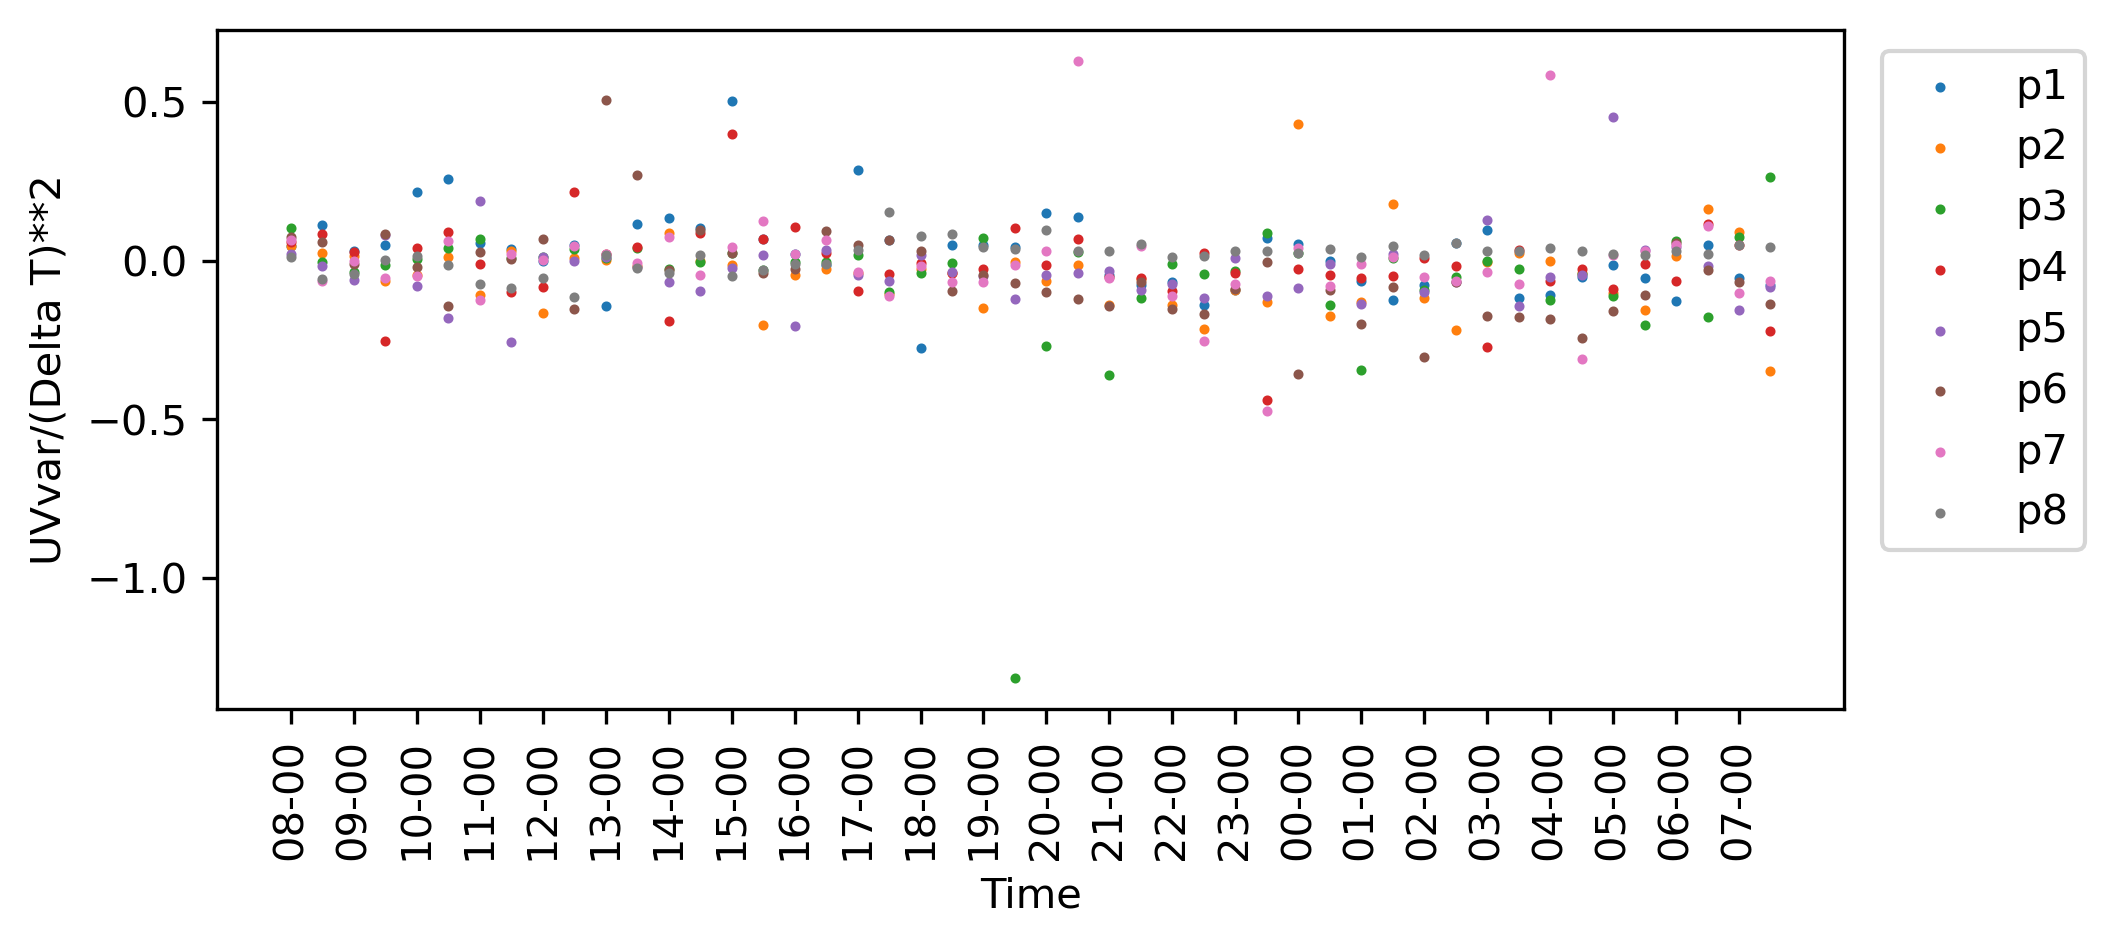

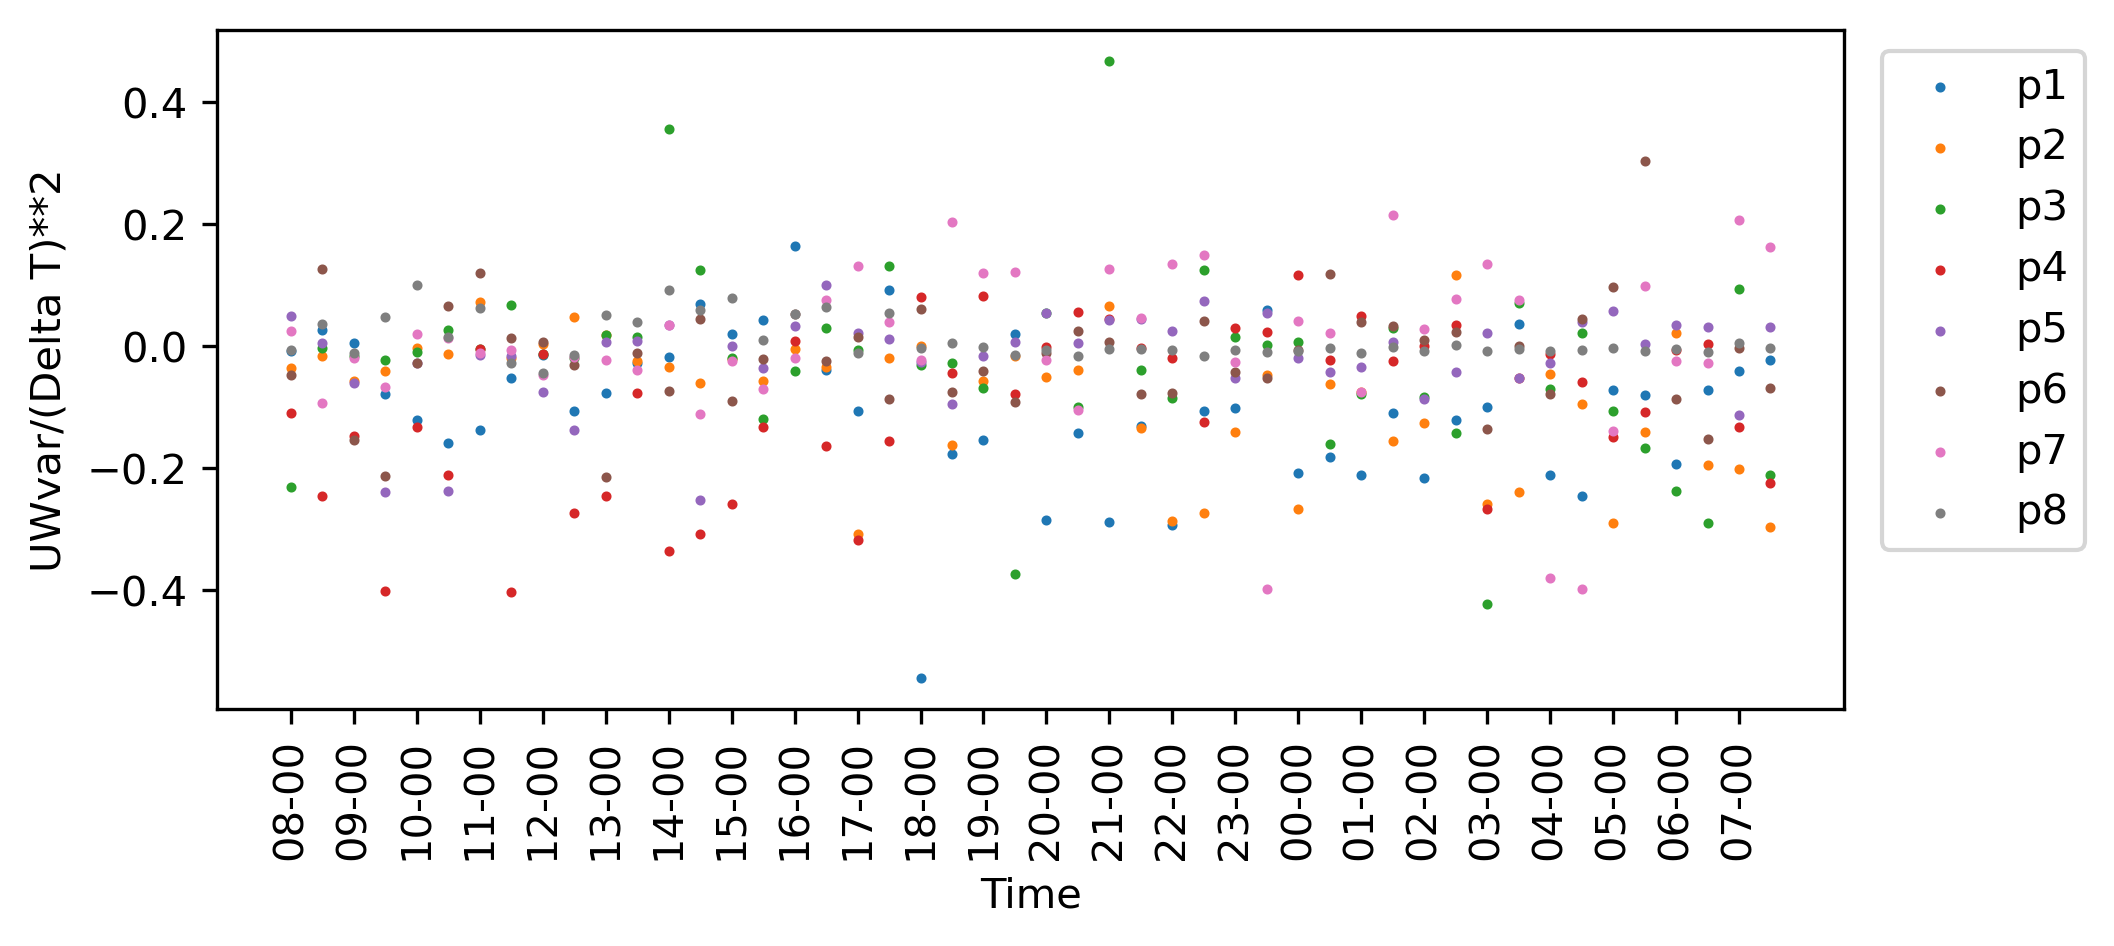

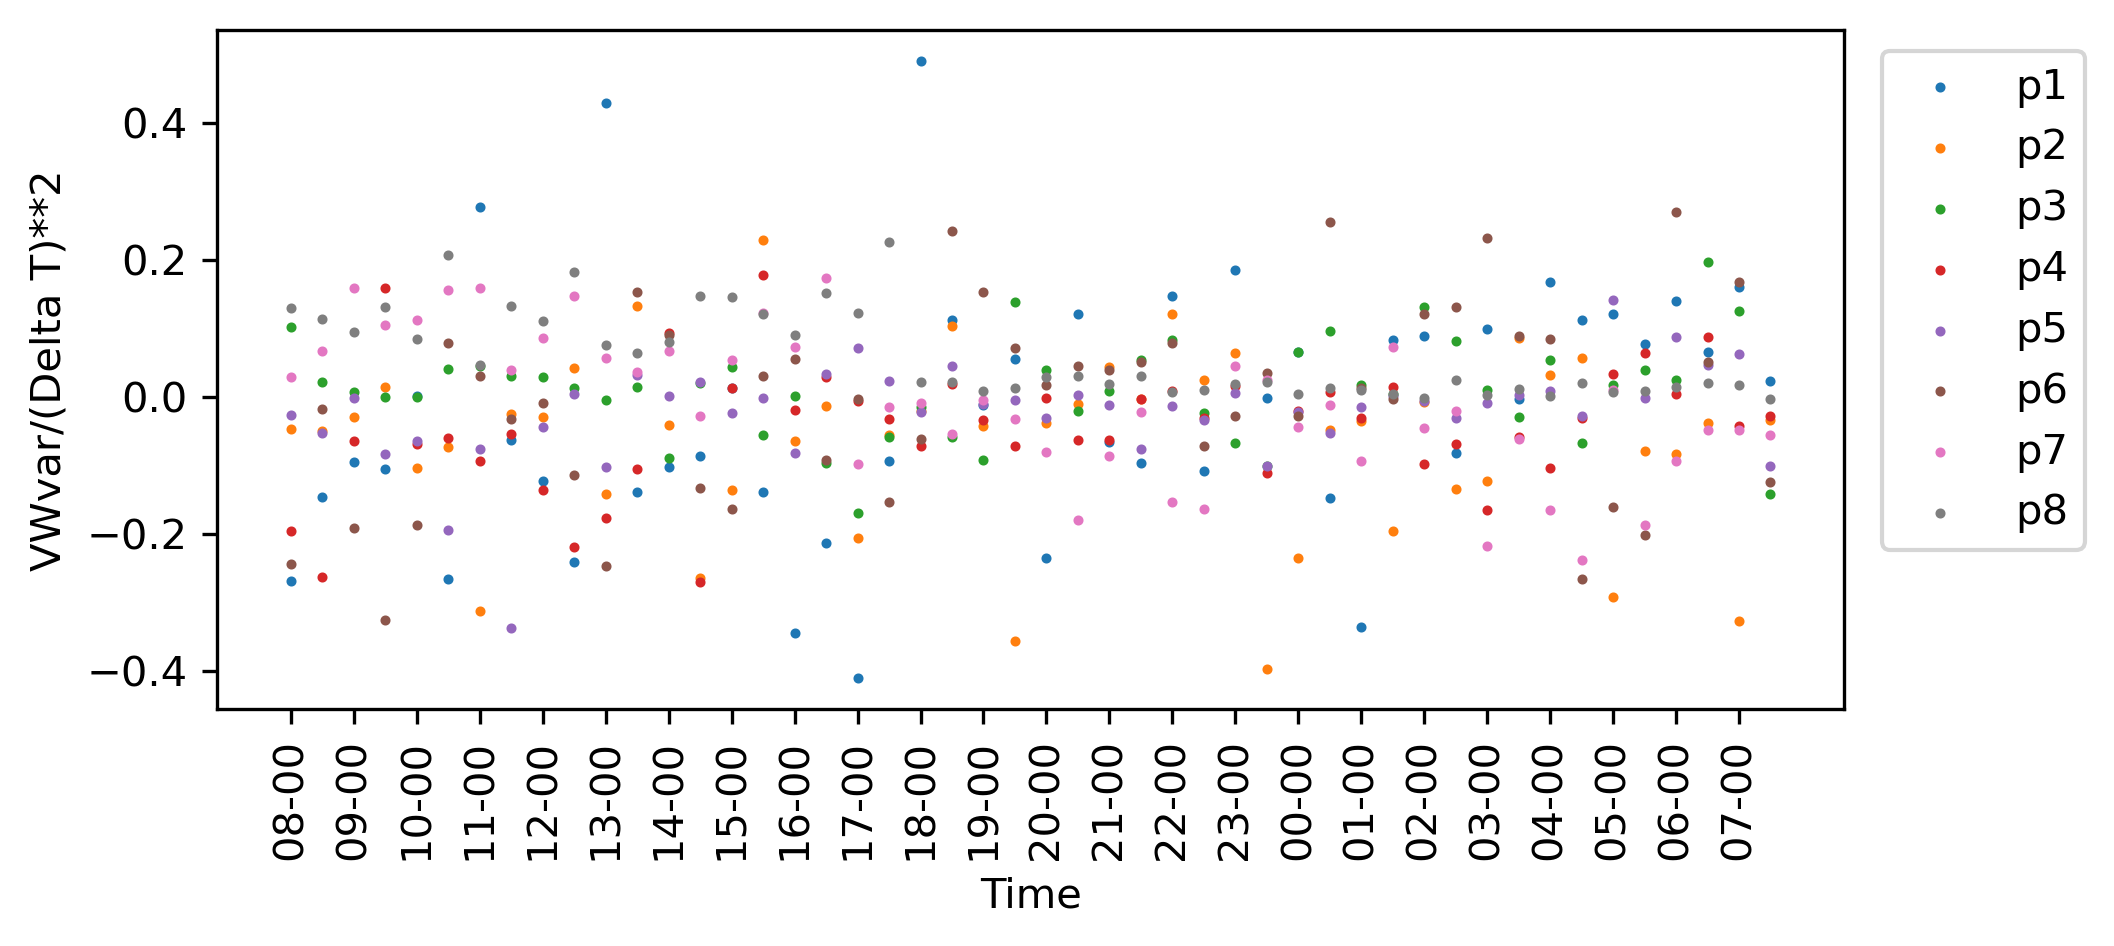

In [162]:
fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'UVvar']/p_data.loc[pd.IndexSlice[:, i], 'Savg']**2,label=i,s=2)
plt.ylabel('UVvar/(Delta T)**2')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'UVvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'UWvar']/p_data.loc[pd.IndexSlice[:, i], 'Savg']**2,label=i,s=2)
plt.ylabel('UWvar/(Delta T)**2')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'UWvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'VWvar']/p_data.loc[pd.IndexSlice[:, i], 'Savg']**2,label=i,s=2)
plt.ylabel('VWvar/(Delta T)**2')
xlabel =plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'VWvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

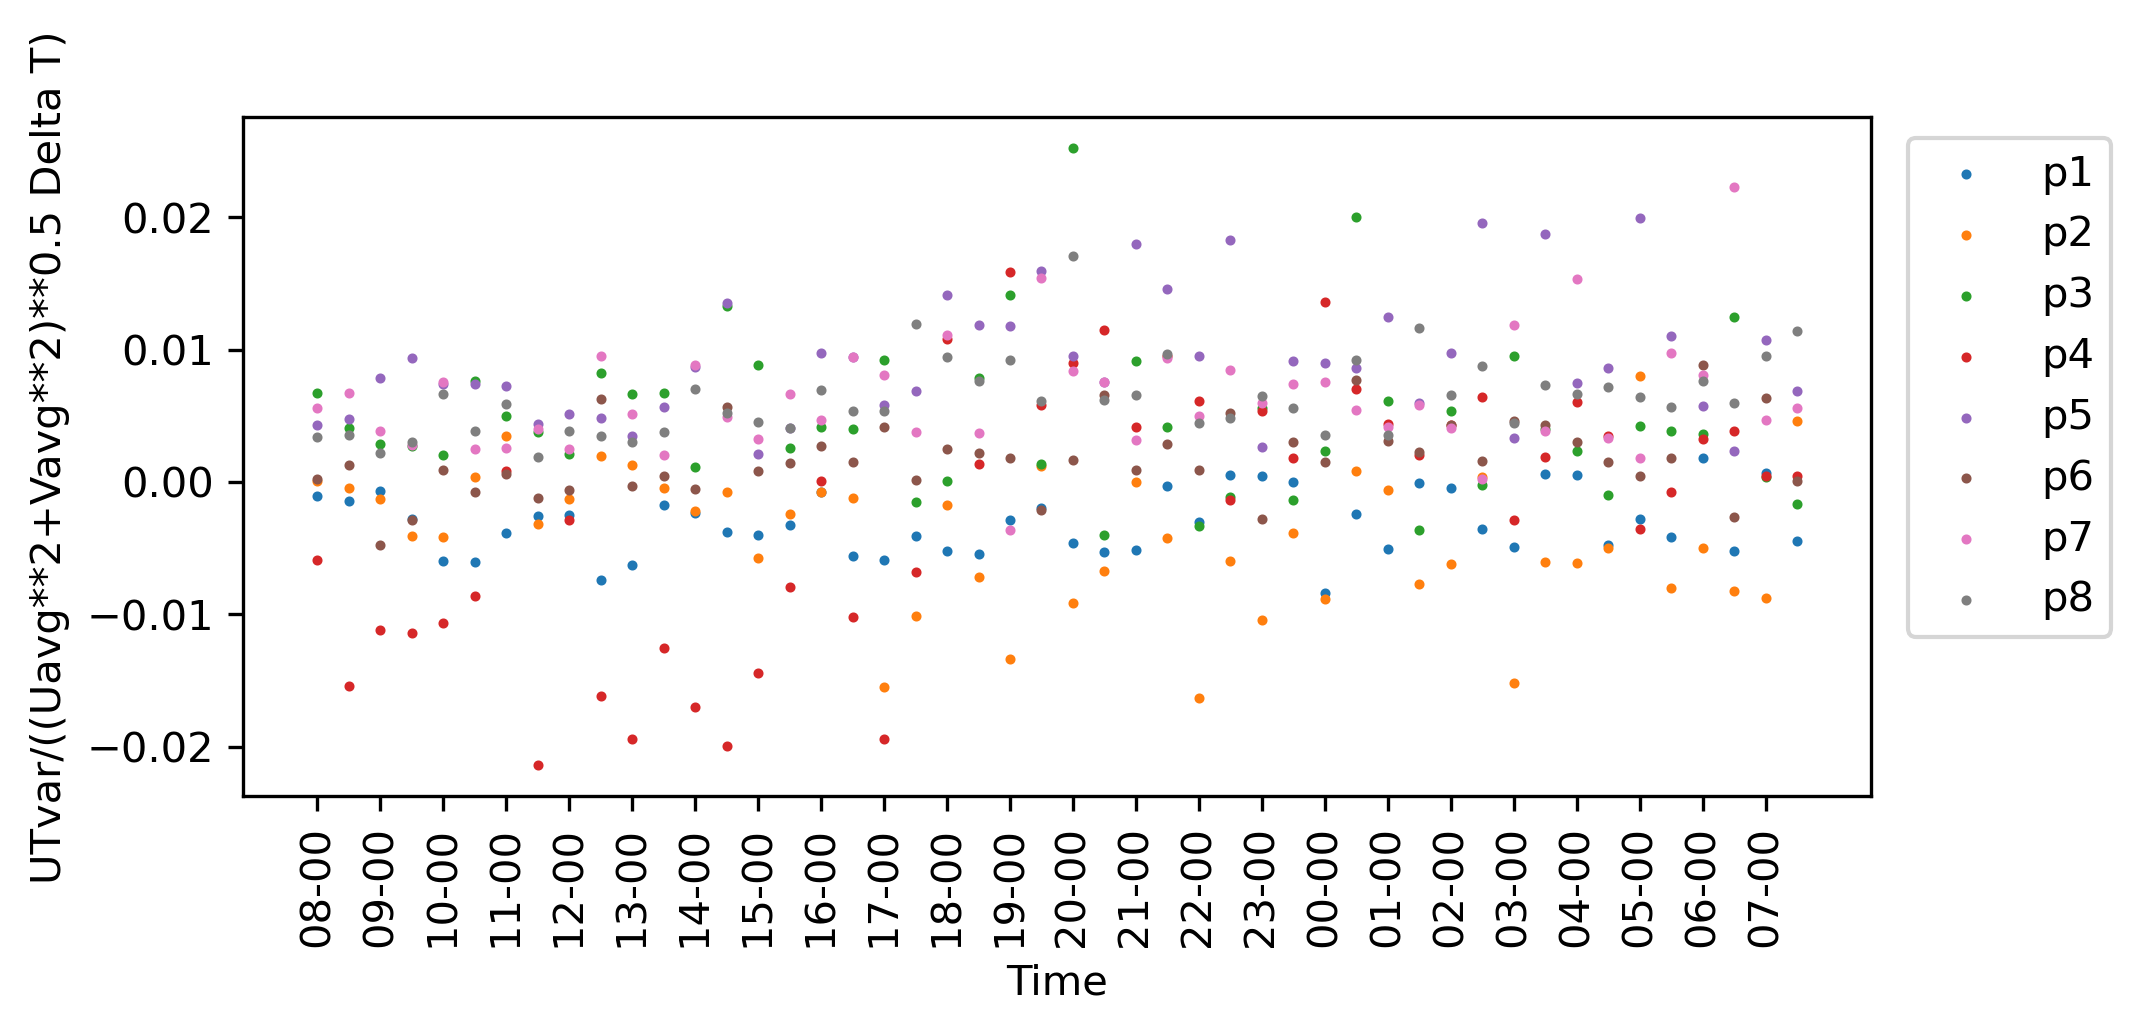

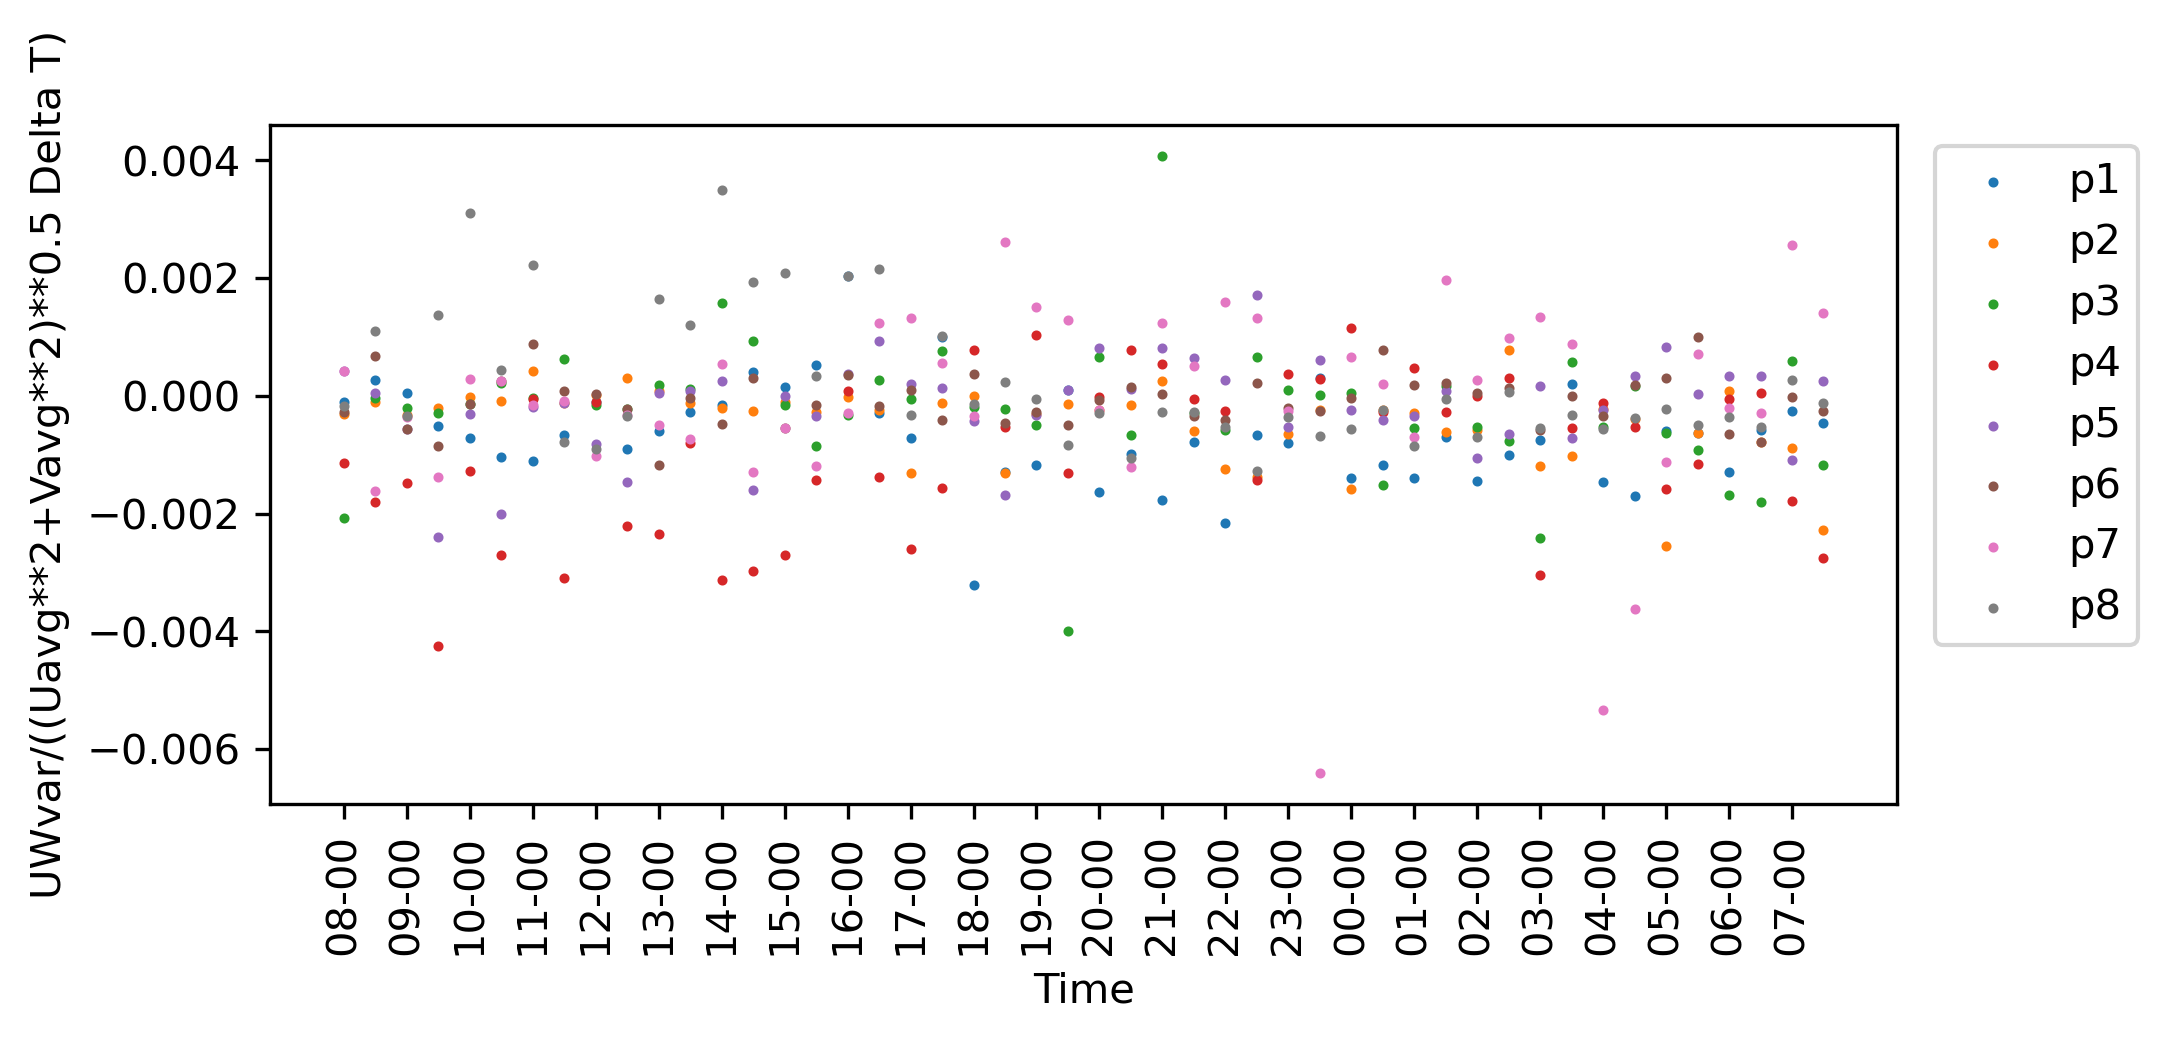

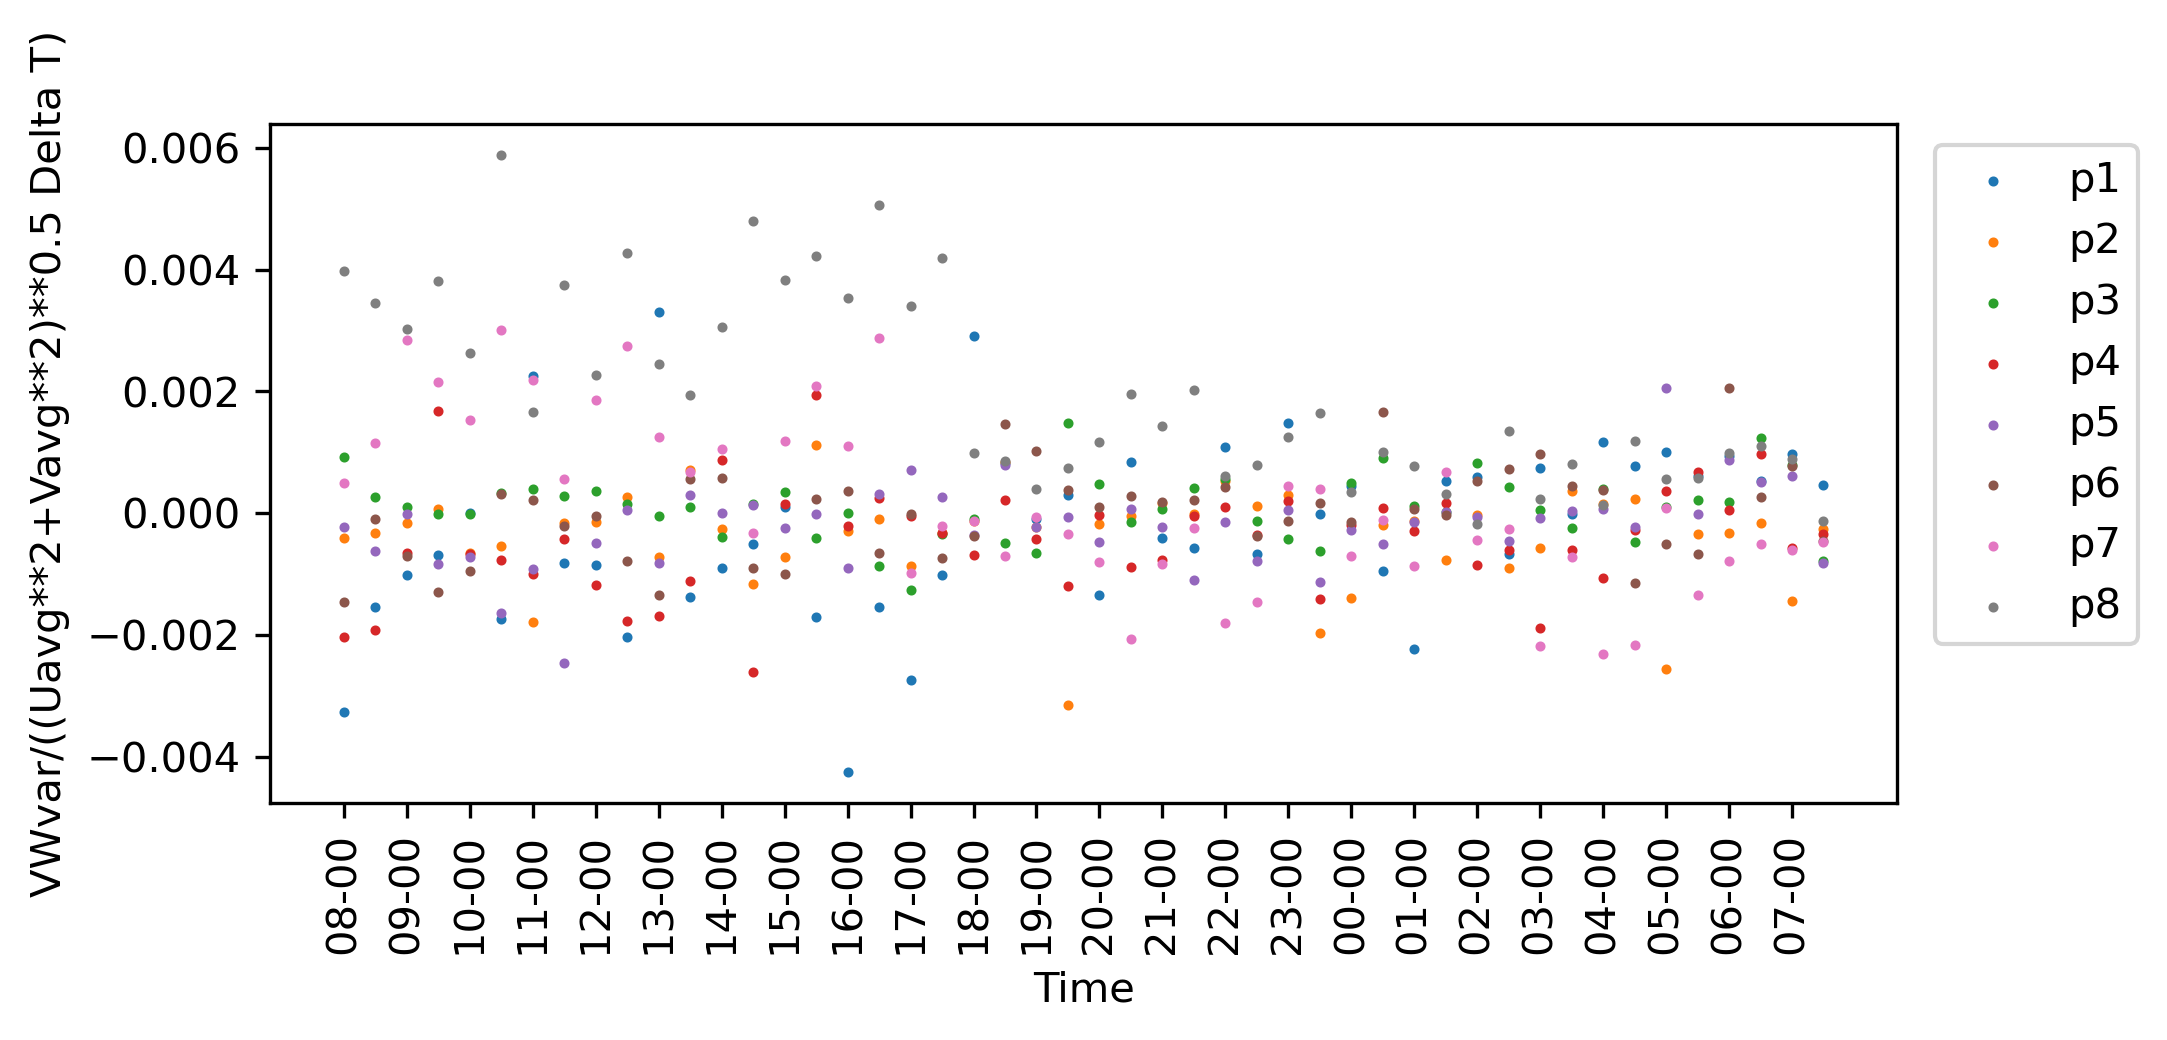

In [163]:
fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'UTvar']/(p_data.loc[pd.IndexSlice[:, i], 'Savg']*DeltaT),label=i,s=2)
plt.ylabel('UTvar/((Uavg**2+Vavg**2)**0.5 Delta T)')
xlabel = plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'UTvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'UWvar']/(p_data.loc[pd.IndexSlice[:, i], 'Savg']*DeltaT),label=i,s=2)
plt.ylabel('UWvar/((Uavg**2+Vavg**2)**0.5 Delta T)')
xlabel = plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'VTvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,3),dpi=300)
ax=plt.subplot(111)
for i in points:
    ax.scatter(files,p_data.loc[pd.IndexSlice[:, i], 'VWvar']/(p_data.loc[pd.IndexSlice[:, i], 'Savg']*DeltaT),label=i,s=2)
plt.ylabel('VWvar/((Uavg**2+Vavg**2)**0.5 Delta T)')
xlabel = plt.xlabel('Time')
plt.xticks(rotation=90)
lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(x_axis_labels)
plt.savefig(figsavepath+'WTvar.pdf', format='pdf',bbox_extra_artists=(lgd,xlabel), bbox_inches='tight')
plt.show()